# Radom Forest สำหรับทำนายราคาน้ำมัน Brent
คู่ทำ คือ
1. มาวิน
2. โต๋เต๋

## 1. Import Libraries

In [16]:
import sys
from lib_import import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## 2. Loading data and Explore data

In [17]:
df = pd.read_csv('../data/processed/merged_oil_prices.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.head()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
0,2017-11-02,56.73,56.73,56.73,56.73,0,56.73,51.32,51.32,51.32,51.32,0,51.32
1,2017-11-03,56.84,56.84,56.84,56.84,0,56.84,51.39,51.39,51.39,51.39,0,51.39
2,2017-11-06,57.26,57.26,57.26,57.26,0,57.26,51.07,51.07,51.07,51.07,0,51.07
3,2017-11-07,57.40,57.40,57.40,57.40,0,57.40,51.43,51.43,51.43,51.43,0,51.43
4,2017-11-08,58.17,58.17,58.17,58.17,0,58.17,52.22,52.22,52.22,52.22,0,52.22


In [18]:
df.describe()

,date,open_x,high_x,low_x,close_x,volume_x,average_x,open_y,high_y,low_y,close_y,volume_y,average_y
count,1846,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000,1846.000000
mean,2021-07-17 19:40:14.301191680,65.546100,65.597969,65.481219,65.537378,74.929577,65.539395,60.055937,60.190195,59.891966,60.033364,890.858072,60.043776
min,2017-11-02 00:00:00,46.440000,46.440000,46.440000,46.440000,0.000000,46.440000,40.390000,40.390000,40.390000,40.390000,0.000000,40.390000
25%,2019-09-13 18:00:00,57.990000,57.990000,57.990000,57.990000,0.000000,57.990000,52.052500,52.052500,52.052500,52.052500,0.000000,52.052500
50%,2021-07-12 12:00:00,63.440000,63.440000,63.440000,63.440000,0.000000,63.440000,55.770000,55.770000,55.770000,55.770000,0.000000,55.770000
75%,2023-05-29 00:00:00,74.800000,74.975000,74.587500,74.767500,0.000000,74.796500,69.877500,70.220000,69.577500,69.877500,98.000000,69.944000
max,2025-04-03 00:00:00,83.930000,83.930000,83.930000,83.930000,11399.000000,83.930000,79.010000,79.140000,79.010000,79.010000,35933.000000,79.010000
std,NaN,9.821117,9.866789,9.767207,9.814503,572.919216,9.815091,10.131954,10.268160,9.966742,10.108302,2817.752398,10.120639


In [19]:
print('Missing:')
print(df.isnull().sum())

Missing:
date         0
open_x       0
high_x       0
low_x        0
close_x      0
volume_x     0
average_x    0
open_y       0
high_y       0
low_y        0
close_y      0
volume_y     0
average_y    0
dtype: int64


## 3. Feature Engineering

In [20]:
print("\n" + "=" * 60)
print("  Part 3: Feature Engineering")
print("=" * 60)

# ใช้ merged_oil_prices เป็นข้อมูลหลัก
# คอลัมน์ _x = Brent, _y = WTI
df = df.copy()

# --- 3.1 Lagged Features: ราคาย้อนหลัง 1, 3, 5, 7 วัน ---
print("\nสร้าง Lagged Features...")
for lag in [1, 3, 5, 7]:
    df[f'brent_close_lag_{lag}'] = df['close_x'].shift(lag)
    df[f'wti_close_lag_{lag}'] = df['close_y'].shift(lag)
    df[f'brent_volume_lag_{lag}'] = df['volume_x'].shift(lag)

print("  - brent_close_lag_1, brent_close_lag_3, brent_close_lag_5, brent_close_lag_7")
print("  - wti_close_lag_1, wti_close_lag_3, wti_close_lag_5, wti_close_lag_7")
print("  - brent_volume_lag_1, brent_volume_lag_3, brent_volume_lag_5, brent_volume_lag_7")

# --- 3.2 Moving Averages: ค่าเฉลี่ย 5 และ 10 วัน ---
print("\nสร้าง Moving Averages...")
df['brent_close_ma_5'] = df['close_x'].rolling(window=5).mean()
df['brent_close_ma_10'] = df['close_x'].rolling(window=10).mean()
df['wti_close_ma_5'] = df['close_y'].rolling(window=5).mean()
df['wti_close_ma_10'] = df['close_y'].rolling(window=10).mean()

print("  - brent_close_ma_5, brent_close_ma_10")
print("  - wti_close_ma_5, wti_close_ma_10")

# --- 3.3 Features เพิ่มเติม ---
print("\nสร้าง Features เพิ่มเติม...")
df['brent_high_low_diff'] = df['high_x'] - df['low_x']
df['wti_high_low_diff'] = df['high_y'] - df['low_y']
df['brent_open_close_diff'] = df['close_x'] - df['open_x']
df['brent_wti_spread'] = df['close_x'] - df['close_y']

print("  - brent_high_low_diff (ส่วนต่าง High-Low ของ Brent)")
print("  - wti_high_low_diff (ส่วนต่าง High-Low ของ WTI)")
print("  - brent_open_close_diff (ส่วนต่าง Close-Open ของ Brent)")
print("  - brent_wti_spread (ส่วนต่างราคา Brent-WTI)")

# --- 3.4 Target: ราคา Brent วันถัดไป ---
print("\nสร้าง Target Variable...")
df['target_brent_next_day'] = df['close_x'].shift(-1)
print("  - target_brent_next_day (ราคาปิด Brent วันถัดไป)")

# --- 3.5 ลบแถวที่มี NaN (จาก lag และ rolling) ---
df_clean = df.dropna().reset_index(drop=True)
print(f"\nจำนวนข้อมูลก่อนทำความสะอาด: {len(df)}")
print(f"จำนวนข้อมูลหลังทำความสะอาด: {len(df_clean)}")

# แสดง features ทั้งหมด
feature_cols = [
    # Lagged features - Brent
    'brent_close_lag_1', 'brent_close_lag_3', 'brent_close_lag_5', 'brent_close_lag_7',
    # Lagged features - WTI
    'wti_close_lag_1', 'wti_close_lag_3', 'wti_close_lag_5', 'wti_close_lag_7',
    # Lagged features - Volume
    'brent_volume_lag_1', 'brent_volume_lag_3', 'brent_volume_lag_5', 'brent_volume_lag_7',
    # Moving averages
    'brent_close_ma_5', 'brent_close_ma_10',
    'wti_close_ma_5', 'wti_close_ma_10',
    # Price differences
    'brent_high_low_diff', 'wti_high_low_diff',
    'brent_open_close_diff', 'brent_wti_spread',
    # Original features
    'open_x', 'high_x', 'low_x', 'close_x', 'volume_x', 'average_x',
    'open_y', 'high_y', 'low_y', 'close_y', 'volume_y', 'average_y',
]

target_col = 'target_brent_next_day'

print(f"\nจำนวน Features ทั้งหมด: {len(feature_cols)}")
print(f"Features: {feature_cols}")



  Part 3: Feature Engineering

สร้าง Lagged Features...
  - brent_close_lag_1, brent_close_lag_3, brent_close_lag_5, brent_close_lag_7
  - wti_close_lag_1, wti_close_lag_3, wti_close_lag_5, wti_close_lag_7
  - brent_volume_lag_1, brent_volume_lag_3, brent_volume_lag_5, brent_volume_lag_7

สร้าง Moving Averages...
  - brent_close_ma_5, brent_close_ma_10
  - wti_close_ma_5, wti_close_ma_10

สร้าง Features เพิ่มเติม...
  - brent_high_low_diff (ส่วนต่าง High-Low ของ Brent)
  - wti_high_low_diff (ส่วนต่าง High-Low ของ WTI)
  - brent_open_close_diff (ส่วนต่าง Close-Open ของ Brent)
  - brent_wti_spread (ส่วนต่างราคา Brent-WTI)

สร้าง Target Variable...
  - target_brent_next_day (ราคาปิด Brent วันถัดไป)

จำนวนข้อมูลก่อนทำความสะอาด: 1846
จำนวนข้อมูลหลังทำความสะอาด: 1836

จำนวน Features ทั้งหมด: 32
Features: ['brent_close_lag_1', 'brent_close_lag_3', 'brent_close_lag_5', 'brent_close_lag_7', 'wti_close_lag_1', 'wti_close_lag_3', 'wti_close_lag_5', 'wti_close_lag_7', 'brent_volume_lag_1', 'brent

## 4. Prepare information for training

In [21]:
X = df_clean[feature_cols]
y = df_clean[target_col]

# แบ่งข้อมูล Train/Test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"\nขนาด Training set : {X_train.shape}")
print(f"ขนาด Testing set  : {X_test.shape}")
print(f"\nช่วง Training: index {X_train.index[0]} - {X_train.index[-1]}")
print(f"ช่วง Testing : index {X_test.index[0]} - {X_test.index[-1]}")


ขนาด Training set : (1468, 32)
ขนาด Testing set  : (368, 32)

ช่วง Training: index 0 - 1467
ช่วง Testing : index 1468 - 1835


## 5. Build and Train Random Forest Model

In [22]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

print("\nModel Configuration:")
print(f"  - n_estimators    : 100")
print(f"  - max_depth       : None (ไม่จำกัด)")
print(f"  - min_samples_split: 2")
print(f"  - min_samples_leaf : 1")
print(f"  - random_state    : 42")
print(f"  - n_jobs          : -1 (ใช้ทุก CPU cores)")

# Train model
print('=' * 50)

rf_model.fit(X_train, y_train)


Model Configuration:
  - n_estimators    : 100
  - max_depth       : None (ไม่จำกัด)
  - min_samples_split: 2
  - min_samples_leaf : 1
  - random_state    : 42
  - n_jobs          : -1 (ใช้ทุก CPU cores)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Evaluate result

In [23]:
# Prediction
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)

# calculate metrics for Training set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
train_metrics = {
    "MSE": train_mse,
    "RMSE": train_rmse,
    "MAE": train_mae,
    "R2": train_r2
}

# calculate metrics for Test set
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# keep metrics by dictionary
test_metrics = {
    "MSE": mse,
    "RMSE": rmse,
    "MAE": mae,
    "R2": r2
}

print('=' * 50)
print('MODEL PERFORMANCE')
print('=' * 50)
print('\nTraining Set Results:')
print(f'  MSE:  ${train_metrics["MSE"]:.4f}')
print(f'  RMSE: ${train_metrics["RMSE"]:.4f}')
print(f'  MAE:  ${train_metrics["MAE"]:.4f}')
print(f'  R²:   {train_metrics["R2"]:.4f}')
print('\nTest Set Results:')
print(f'  MSE:  ${test_metrics["MSE"]:.4f}')
print(f'  RMSE: ${test_metrics["RMSE"]:.4f}')
print(f'  MAE:  ${test_metrics["MAE"]:.4f}')
print(f'  R²:   {test_metrics["R2"]:.4f}')


MODEL PERFORMANCE

Training Set Results:
  MSE:  $0.0920
  RMSE: $0.3033
  MAE:  $0.2188
  R²:   0.9989

Test Set Results:
  MSE:  $1.1129
  RMSE: $1.0549
  MAE:  $0.8200
  R²:   0.8853


## 7. Visualization

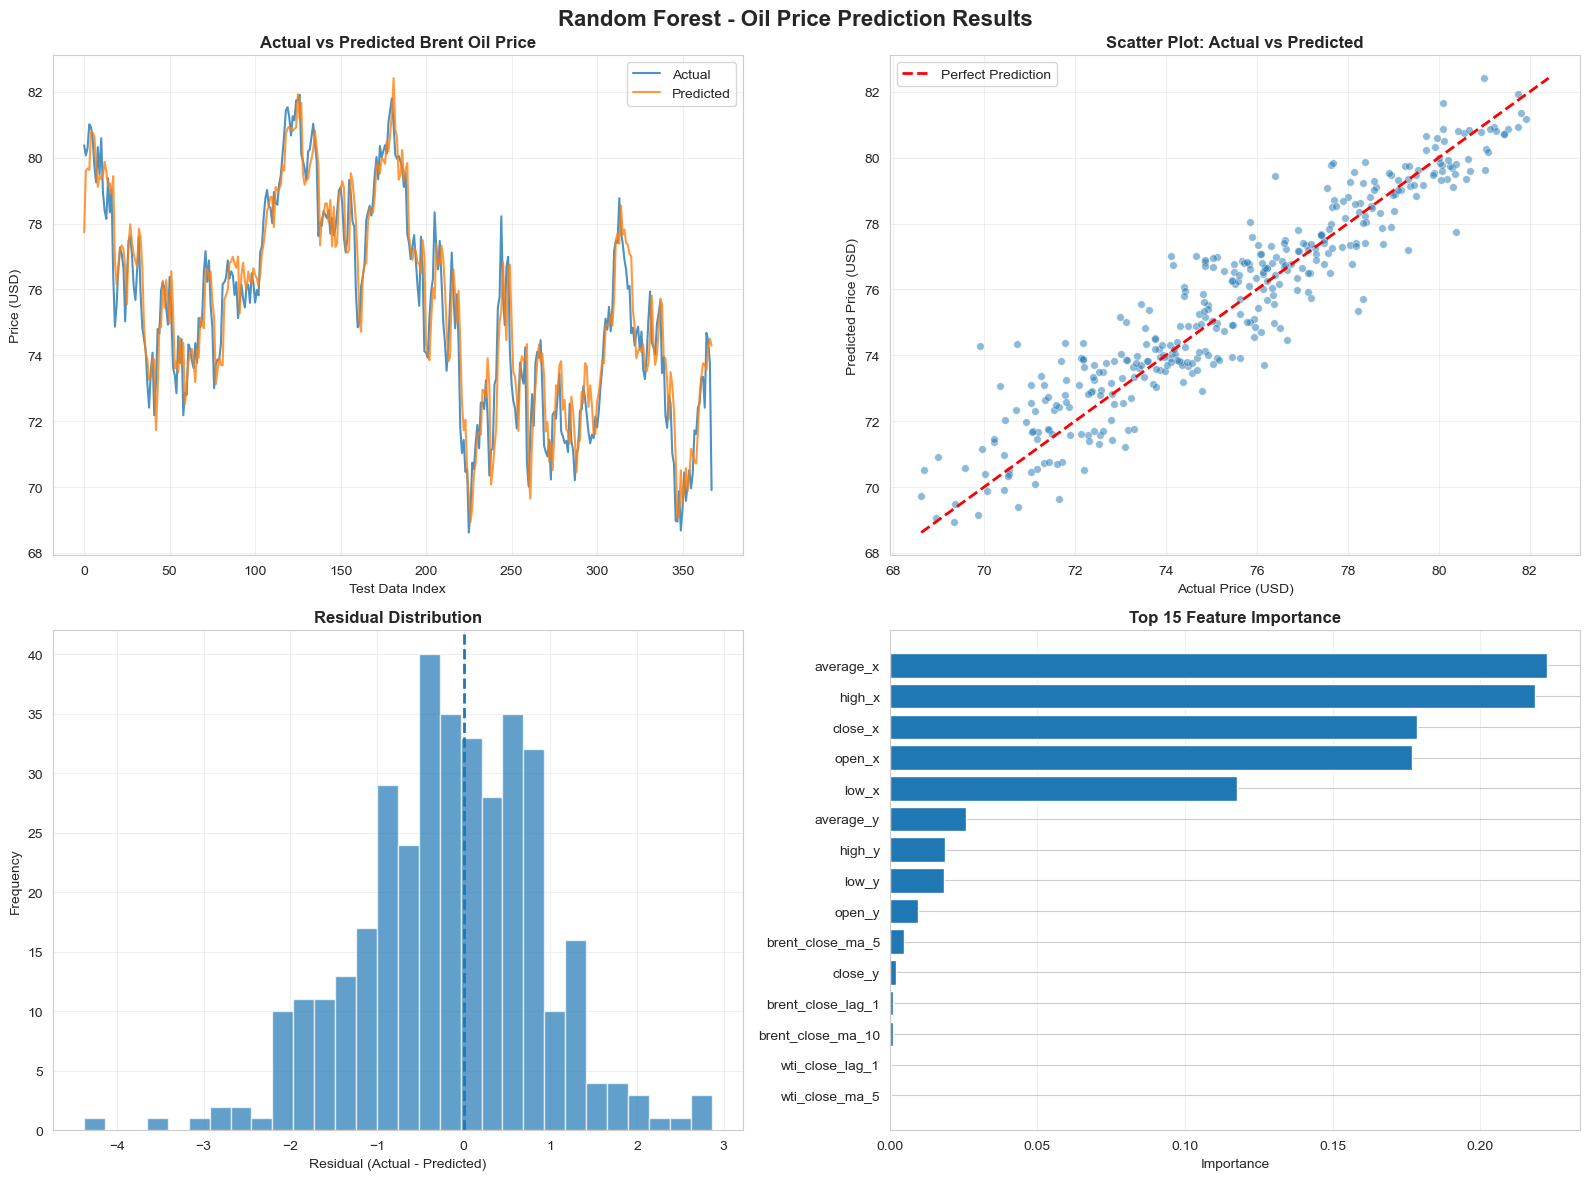

In [24]:
# --- 6.1 กราฟ Actual vs Predicted ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Random Forest - Oil Price Prediction Results', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted (Line)
ax1 = axes[0, 0]
ax1.plot(range(len(y_test)), y_test.values, label='Actual', linewidth=1.5, alpha=0.8)
ax1.plot(range(len(y_pred)), y_pred, label='Predicted', linewidth=1.5, alpha=0.8)
ax1.set_title('Actual vs Predicted Brent Oil Price', fontsize=12, fontweight='bold')
ax1.set_xlabel('Test Data Index')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Scatter Plot
ax2 = axes[0, 1]
ax2.scatter(y_test, y_pred, alpha=0.5, edgecolors='white', linewidth=0.5, s=30)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title('Scatter Plot: Actual vs Predicted', fontsize=12, fontweight='bold')
ax2.set_xlabel('Actual Price (USD)')
ax2.set_ylabel('Predicted Price (USD)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Residual Distribution
ax3 = axes[1, 0]
residuals = y_test.values - y_pred
ax3.hist(residuals, bins=30, edgecolor='white', alpha=0.7)
ax3.axvline(x=0, linestyle='--', linewidth=2)
ax3.set_title('Residual Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Residual (Actual - Predicted)')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Plot 4: Feature Importance (Top 15)
ax4 = axes[1, 1]
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=True).tail(15)

ax4.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
ax4.set_title('Top 15 Feature Importance', fontsize=12, fontweight='bold')
ax4.set_xlabel('Importance')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()

## 8. Final Summary

In [25]:
print('=' * 50)
print('FINAL RESULTS SUMMARY')
print('=' * 50)
print(f'  MSE:  ${test_metrics["MSE"]:.4f}')
print(f'  RMSE: ${test_metrics["RMSE"]:.4f}')
print(f'  MAE:  ${test_metrics["MAE"]:.4f}')
print(f'  R²:   {test_metrics["R2"]:.4f}')
print('\n' + '=' * 50)

FINAL RESULTS SUMMARY
  MSE:  $1.1129
  RMSE: $1.0549
  MAE:  $0.8200
  R²:   0.8853



## 9. Model Performance Comparison Charts

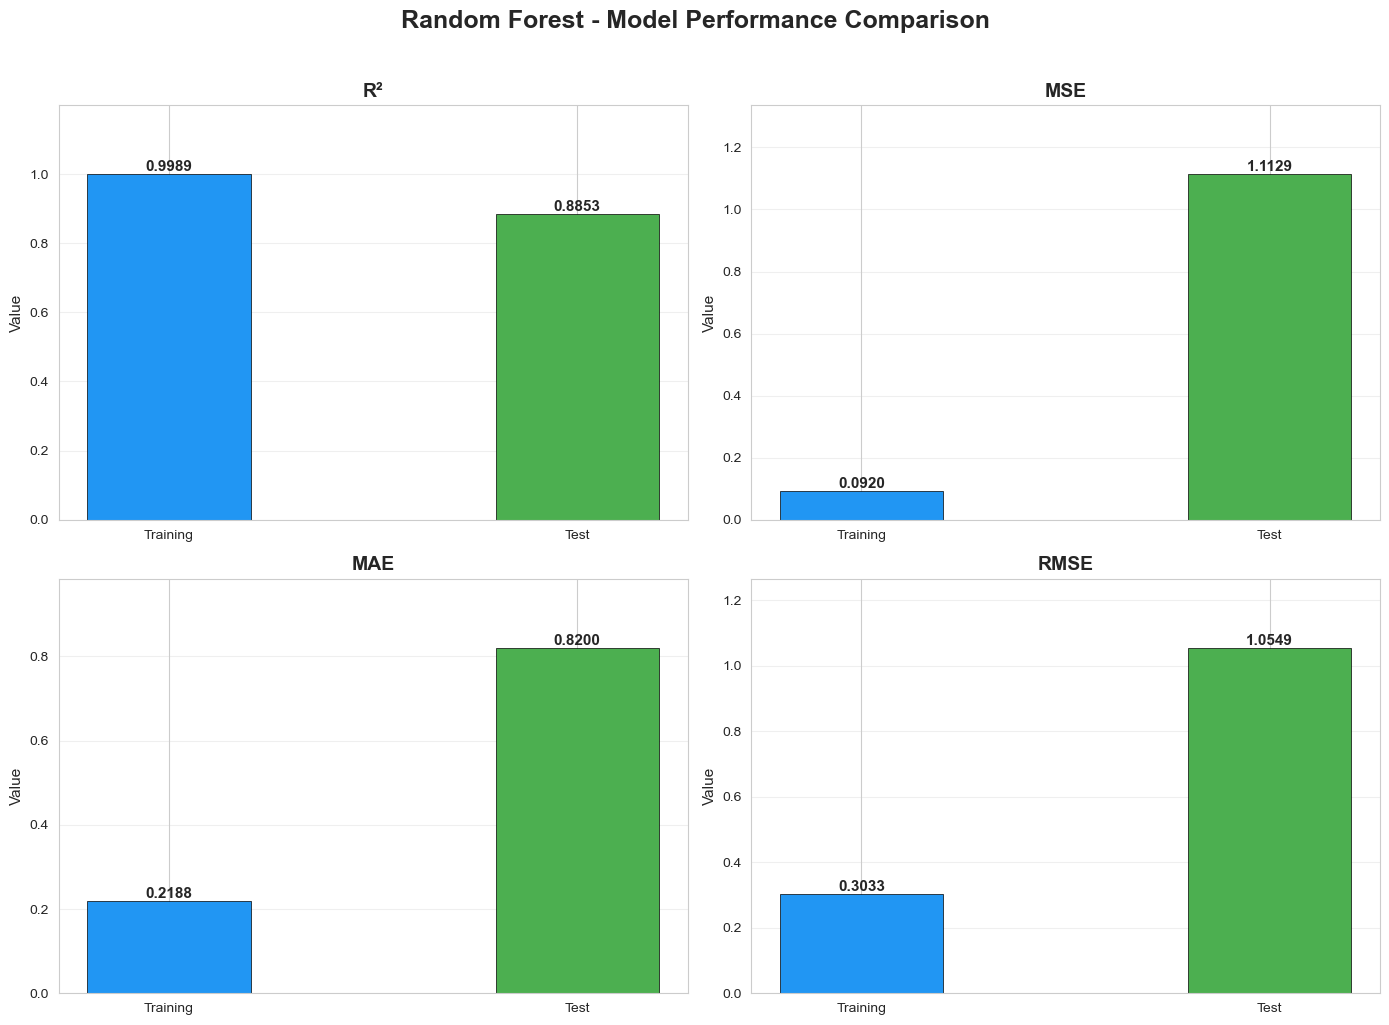

In [ ]:
# Comparison bar charts for R2, MSE, MAE, RMSE
import numpy as np

metrics_names = ['R²', 'MSE', 'MAE', 'RMSE']
metrics_keys = ['R2', 'MSE', 'MAE', 'RMSE']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Random Forest - Model Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

colors = ['#2196F3', '#4CAF50']
labels = ['Training', 'Test']

for idx, (ax, name, key) in enumerate(zip(axes.flat, metrics_names, metrics_keys)):
    values = [train_metrics[key], test_metrics[key]]
    bars = ax.bar(labels, values, color=colors, edgecolor='black', linewidth=0.5, width=0.4)

    # Add value labels on top of each bar
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    ax.set_title(name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Value', fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(values) * 1.2)

plt.tight_layout()
plt.show()
